# Project 4

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing

from functions import *

% matplotlib inline

## 1. Data preparation

Our data preparation process requires three functions: `load_data()`, `clean()`, and `join_with_weather()`, and each of these functions will use other helper functions as well. All of them can be found in the `functions.py` file in this project's root directory. Each function is described below.

The `load_data()` funciton joins all 1,600 CSV files into a single pandas dataframe, with two data cleaning procedures at a CSV file level. First, those `course_over_ground` values which are equal to `-1` are marked as missing values (using `None`). Second, a `north_proportion` variable is added with the percentage of *north values* found for the file.

The `north_proportion` variable is created at a file level, but after some analysis I'm afraid that it seems that each CSV contains data for more than one trip, because many of the `north_proportion` values, which are calculated by getting the number of observations in a CSV file which are broadly pointing north (less than 90 degrees or more than 270 in the `course_over_ground` variable) and dividing it by the total number of observations for the CSV file, are between 0.45 and 0.55, which means that the vehicle was half of the time driving north, and the other half driving south, which probably means that there are multiple trips recorded within each file. This renders our possibility to identify trip direction fruitless, and we won't be able to use that for predictions since there's no *trip ID* or similar variable.

The `clean()` function cleans data at a fully integrated dataframe level by performing four procedures. First, it removes the `id` variable as it's not useful for the analysis. Second, splits the timestamp string into the corresponding `year`, `month`, `day`, `hour`, and `minute` variables. A specific function is created for each of them (as can be seen in the `functions.py` file). Third, all numeric variables (including speed and the mentioned split dates and times) are converted to numeric variables. Fourth, it uses the split date values to find the week day using the `datetime` Python module.

The `join_with_weather()` function uses the `weather.csv` file found in this project's root directory, which I purchased from OpenWeatherMap (https://openweathermap.org/) to integrate weather variables: `temperateure`, `weather_main` (4 categories for: *Clear*, *Clouds*, *Drizzle*, *Rain*), and `weather_description` (10 categories for: *broken clouds*, *drizzle*, *few clouds*, *light intensity shower rain*, *light rain*, *moderate rain*, *overcast clouds*, *scattered clouds*, *sky is clear*). These are filled in according to the day and hour values. The timestamps in this project's data as well as in the weather data were given in ISO UTC formats, so the same split mechanism was applied and no timezone conversion was necessary. The temperature data is transformed from Kelvin to Celsius.

I should mention that the `weather.csv` I purchased did not cotnain observations for every hour of the day, so I had to go there and fill in those missing observations. What I did was first add space for any missing observations (guided by timestamps), and input a the average of the previous and next values for temperature, and copy the previous value for weather main and weather description, since those are categorical values I can't average.

Using a standard for-loop to integrate the weather data was not feasible since it took too much time. Using the `.apply()` method on the dataframe proved to be much faster, however, it's still not a fast procedure, since it takes almost 5 mins.

In [2]:
data = load_data()

In [3]:
data = clean(data)

In [4]:
data = join_with_weather(data)

## 2. Descriptive analysis

The `weather_main` variable has 80% of its observations in two of the four values: *Clouds* and *Rain*, which may not be enough information to produce generate good predictive power. The `weather_description`, which is a more disaggregated version of this information, does show more spread of data having 61% of the data spread over three values: *borken clouds*, *light rain*, and *scattered clouds*. This may produce a better predictive power, but will be validated in the appropriate section.

In [5]:
t = pd.crosstab(index=data.weather_main, columns='percentage')
t / t.sum() * 100

col_0,percentage
weather_main,
Clear,17.564274
Clouds,32.835153
Drizzle,1.842822
Rain,47.757750


In [8]:
t = pd.crosstab(index=data.weather_description, columns='percentage')
t / t.sum() * 100

col_0,percentage
weather_description,
broken clouds,15.532134
drizzle,1.842822
few clouds,5.063507
light intensity shower rain,9.223762
light rain,35.960389
moderate rain,2.573600
overcast clouds,2.057406
scattered clouds,10.182107
sky is clear,17.564274


The temperature seems to have only integer values, as can be seen by the spikes at integer values, and has a range between 10 and 19 Celsius degrees. This gives us approximately 10 values I can use for the predictive models.

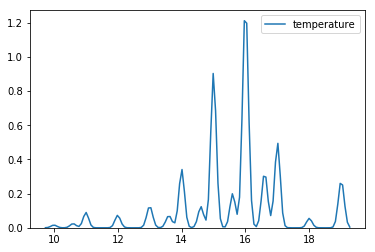

In [9]:
sns.kdeplot(data.temperature)

In the case of the `course_over_ground` variable, there are two main spikes: around 150, and 350. Note that the seemingly third spike, the one around 40, is just the *sub-spike* of the 350 spike, just as the *sub-spike* we see around 200 for the 150 spike. Since we know that 0 is north, 90 is east, 180 is south, and 270 is west, we can see that most of the directions are approximately north or south. There's not too much movement to the east or west, which is what we would expect given the direction of the Northern Motorway.

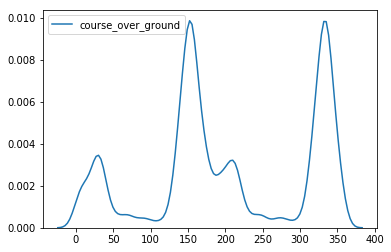

In [11]:
sns.kdeplot(data.course_over_ground[data.course_over_ground != None])

As I mentioned before, it seems that most CSV files contain data for multiple trips because most of the values for `north_proportion` are between 0.4 and 0.6. Given this, this is not a useful variable for our predictive models, and will not be used further after this point.

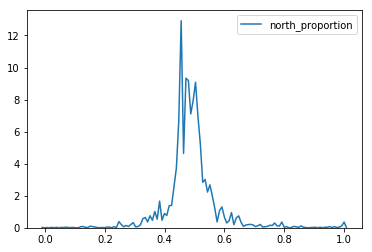

In [12]:
sns.kdeplot(data.north_proportion)

Speed has two spikes, one at 0 signaling stopped vehicles (probably due to traffic), and around 80 KPH, the mean speed at which these vehicles travel.

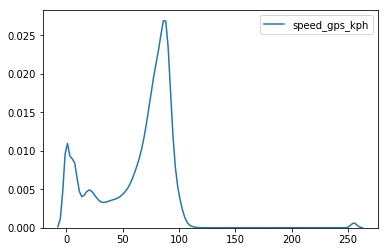

In [13]:
sns.kdeplot(data.speed_gps_kph)

As can be seen in the previous graph, some vehicles have a travel distance of over 250. After looking into it, we see that it's a single value of 255 which is present in 2,309 observations (less than 1% of the data). This probably means that the measurement is an error or is missing, so we will marked such values with `None` instead.

In [14]:
data.loc[data.speed_gps_kph > 150, 'speed_gps_kph'] = None

Finally, note that most vehicles are classified as being heavy (around 82%). We must consider this when evaluating our predictive models.

In [16]:
t = pd.crosstab(index=data.vehicle_weight_type, columns='percentage')
t / t.sum() * 100

col_0,percentage
vehicle_weight_type,
HEAVY,82.005625
LIGHT,17.994375


## 3. Predictive modeling

### Split data into training and testing sets, and normalize it

To prepare our data for the Neural Network models I will develop using TensorFlow, we need a specific format, where all categorical variables are coded as numeric values. I also produce train and test samples to validate our results with *un-seen* observations, and we normalize all variables useing Scikit-learn's `MaxMinScaler()`. Even though it's not necessary to normalize data in the case of Neural Networks, it does help with training speed and I found a bit of an improvement in the prediction results when applied.

In [18]:
data = data.dropna()

data['weather_main_map'] = data['weather_main'].map({
    'Clear': 0, 'Clouds': 1, 'Drizzle': 2, 'Rain': 3
})
data['weight_map'] = data['vehicle_weight_type'].map({
    'HEAVY': 1, 'LIGHT': 0
})
data['weekday_map'] = data['weekday'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
})

sample = np.random.rand(len(data)) < 0.7

data_train = data[sample]
data_test = data[~sample]

numeric_variables = [
    'course_over_ground', 'latitude', 'longitude',
    'speed_gps_kph', 'day', 'hour', 'temperature',
    'weather_main_map', 'weight_map', 'weekday_map'
]

data_train_normalized = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(data_train[numeric_variables]),
    columns=numeric_variables
)
data_test_normalized = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(data_test[numeric_variables]),
    columns=numeric_variables
)

Our parameters for all our moels will be a `batch_size` of 1000, as well as the number of steps taken in the optimization procedure. I changed these parameters to other values, and got very similar results, so I don't optimize for them.

In [19]:
batch_size = 1000
n_steps = 1000

### Predict vehicle weight given direction, speed, date, and time

In this case I will perform classification prediction. We will attempt to predict the weight of a vehicle using the direction, speed, date, and time values.

In [20]:
inputs = ['course_over_ground', 'speed_gps_kph', 'day', 'hour']
output = ['weight_map']

In [21]:
train_X = data_train_normalized[inputs]
train_Y = data_train_normalized[output]

test_X = data_test_normalized[inputs]
test_Y = data_test_normalized[output]

In [22]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=[tf.feature_column.numeric_column(key=k) for k in train_X.keys()],
    hidden_units=[1024, 512, 256],
    n_classes=2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f782f669690>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpOE6apu', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [23]:
classifier.train(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size), steps=n_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpOE6apu/model.ckpt.
INFO:tensorflow:loss = 691.4798, step = 1
INFO:tensorflow:global_step/sec: 25.4509
INFO:tensorflow:loss = 277.13843, step = 101 (3.933 sec)
INFO:tensorflow:global_step/sec: 26.6007
INFO:tensorflow:loss = 80.49255, step = 201 (3.757 sec)
INFO:tensorflow:global_step/sec: 26.2398
INFO:tensorflow:loss = 240.6494, step = 301 (3.812 sec)
INFO:tensorflow:Saving checkpoints for 391 into /tmp/tmpOE6apu/model.ckpt.
INFO:tensorflow:Loss for final step: 86.71104.


In [24]:
train_result = classifier.evaluate(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:22:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpOE6apu/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:22:10
INFO:tensorflow:Saving dict for global step 391: accuracy = 0.81817853, accuracy_baseline = 0.81817853, auc = 0.50336003, auc_precision_recall = 0.79425, average_loss = 0.4814732, global_step = 391, label/mean = 0.81817853, loss = 480.44254, precision = 0.81817853, prediction/mean = 0.76857615, recall = 1.0


In [25]:
test_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_X, test_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:22:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpOE6apu/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:22:15
INFO:tensorflow:Saving dict for global step 391: accuracy = 0.8179773, accuracy_baseline = 0.8179773, auc = 0.50328624, auc_precision_recall = 0.79435074, average_loss = 0.48178524, global_step = 391, label/mean = 0.8179773, loss = 480.91687, precision = 0.8179773, prediction/mean = 0.7683894, recall = 1.0


In [26]:
print('Training accuracy: {accuracy: 0.5f}'.format(**train_result))
print('Testing  accuracy: {accuracy: 0.5f}'.format(**test_result))

Training accuracy:  0.81818
Testing  accuracy:  0.81798


As can be seen, I get a predictive acccuracy of around 80%, which may seem good, but it must be compared to the balance in the predicted variable. As was mentioned in the previous section, that balance is around 80/20, so there's not a big improvement in that regards, and I could make random guesses with a 80/20 proportion, and would produce aproximately similar results to the ones I got here. I was expecting at least a few percentage points of increased predictive accuracy to conclude this model was useful.

### Predict the driving direction given location, speed, date, and time

In this case, and all of the following, I will attempt regression (instead of classification) to predict numeric values. Specifically in this case I will attempt to predict driving direction given the location, speed, date, and time.

In [27]:
inputs = ['latitude', 'longitude', 'speed_gps_kph', 'day', 'hour']
output = ['course_over_ground']

train_X = data_train_normalized[inputs]
train_Y = data_train_normalized[output]

test_X = data_test_normalized[inputs]
test_Y = data_test_normalized[output]

In [28]:
estimator = tf.estimator.DNNRegressor(
    feature_columns=[tf.feature_column.numeric_column(key=k) for k in train_X.keys()],
    hidden_units=[1024, 512, 256]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7812ea8810>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpFTL4M2', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [29]:
estimator.train(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size), steps=n_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpFTL4M2/model.ckpt.
INFO:tensorflow:loss = 351.95868, step = 1
INFO:tensorflow:global_step/sec: 24.3514
INFO:tensorflow:loss = 75.98566, step = 101 (4.106 sec)
INFO:tensorflow:global_step/sec: 22.6819
INFO:tensorflow:loss = 71.91134, step = 201 (4.410 sec)
INFO:tensorflow:global_step/sec: 25.7789
INFO:tensorflow:loss = 75.740036, step = 301 (3.878 sec)
INFO:tensorflow:Saving checkpoints for 391 into /tmp/tmpFTL4M2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.861729.


In [30]:
train_result = estimator.evaluate(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:22:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpFTL4M2/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:22:45
INFO:tensorflow:Saving dict for global step 391: average_loss = 0.069548555, global_step = 391, loss = 69.39967


In [31]:
test_result = estimator.evaluate(
    input_fn=lambda: input_fn(test_X, test_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:22:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpFTL4M2/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:22:48
INFO:tensorflow:Saving dict for global step 391: average_loss = 0.069739245, global_step = 391, loss = 69.61354


In [32]:
print('Training NRRMSE: {:0.5f}'.format(math.sqrt(train_result['loss']) / float(np.std(test_Y))))
print('Testing  NRRMSE: {:0.5f}'.format(math.sqrt(test_result['loss']) / float(np.std(test_Y))))

Training NRRMSE: 28.00089
Testing  NRRMSE: 28.04400


Our results are not great. The normalized root-mean-squared error (NRRMSE) is around 28, which is very bad. A normalized root-mean-squared error should be lower than one to signify that the model has good predictive power, and in this case, it seems that the predictive power is just not there. Howerver, our results appear to indicate a valid model specification since the NRRMSE for the test set (*unseen* observations by the training algorithm) is practically the same than the one with the train test, which is a sign of model validity.

### Predict the speed of a vehicle given weather conditions

In [33]:
inputs = ['temperature']
output = ['speed_gps_kph']

train_X = data_train_normalized[inputs]
train_Y = data_train_normalized[output]

test_X = data_test_normalized[inputs]
test_Y = data_test_normalized[output]

In [34]:
estimator = tf.estimator.DNNRegressor(
    feature_columns=[tf.feature_column.numeric_column(key=k) for k in train_X.keys()],
    hidden_units=[1024, 512, 256]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7811eb44d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmp8UjPBA', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [35]:
estimator.train(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size), steps=n_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp8UjPBA/model.ckpt.
INFO:tensorflow:loss = 307.85574, step = 1
INFO:tensorflow:global_step/sec: 25.5292
INFO:tensorflow:loss = 80.062744, step = 101 (3.919 sec)
INFO:tensorflow:global_step/sec: 26.2507
INFO:tensorflow:loss = 43.93342, step = 201 (3.809 sec)
INFO:tensorflow:global_step/sec: 28.5458
INFO:tensorflow:loss = 82.53473, step = 301 (3.503 sec)
INFO:tensorflow:Saving checkpoints for 391 into /tmp/tmp8UjPBA/model.ckpt.
INFO:tensorflow:Loss for final step: 16.713766.


In [36]:
train_result = estimator.evaluate(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:23:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8UjPBA/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:23:15
INFO:tensorflow:Saving dict for global step 391: average_loss = 0.061744716, global_step = 391, loss = 61.61254


In [37]:
test_result = estimator.evaluate(
    input_fn=lambda: input_fn(test_X, test_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:23:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8UjPBA/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:23:17
INFO:tensorflow:Saving dict for global step 391: average_loss = 0.05892231, global_step = 391, loss = 58.81611


In [38]:
print('Training NRRMSE: {:0.5f}'.format(math.sqrt(train_result['loss']) / float(np.std(test_Y))))
print('Testing  NRRMSE: {:0.5f}'.format(math.sqrt(test_result['loss']) / float(np.std(test_Y))))

Training NRRMSE: 32.51444
Testing  NRRMSE: 31.76800


Our model seems to be validated by the fact that both NRRMSE are almost identical, but their values imply that they are not useful for predictive purposes.

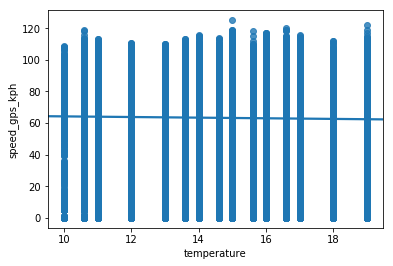

In [39]:
sns.regplot(x='temperature', y='speed_gps_kph', data=data)

As can bee seen in the scatter plot, there doesn't seem to be too much change in speed given the temperature, and that's why my predictive models doesn't have too much predictive power, because there's just not information to leverage for predictions. To get some predictive power, I would have to see some non-uniform pattern in the scatter plot.

**NOTE**: The horizontal blue line is a regression fitted to those values, as can be see, it's useless because it's completely flat, and that means that the model would predict the mean speed regardless of the temperature, which of course lacks predictive power.

### Predict the speed of a vehicle given the day of the week, hour, and direction

Finally, I attempt one last model: predict speed given the day of the week, hour, and direction.

In [40]:
inputs = ['weekday_map', 'weather_main_map', 'hour', 'course_over_ground']
output = ['speed_gps_kph']

train_X = data_train_normalized[inputs]
train_Y = data_train_normalized[output]

test_X = data_test_normalized[inputs]
test_Y = data_test_normalized[output]

In [41]:
estimator = tf.estimator.DNNRegressor(
    feature_columns=[tf.feature_column.numeric_column(key=k) for k in train_X.keys()],
    hidden_units=[1024, 512, 256]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7811806e90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpaXmP2e', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [42]:
estimator.train(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size), steps=n_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpaXmP2e/model.ckpt.
INFO:tensorflow:loss = 285.6865, step = 1
INFO:tensorflow:global_step/sec: 24.0247
INFO:tensorflow:loss = 78.8871, step = 101 (4.164 sec)
INFO:tensorflow:global_step/sec: 24.5879
INFO:tensorflow:loss = 45.547222, step = 201 (4.067 sec)
INFO:tensorflow:global_step/sec: 26.4963
INFO:tensorflow:loss = 88.52734, step = 301 (3.774 sec)
INFO:tensorflow:Saving checkpoints for 391 into /tmp/tmpaXmP2e/model.ckpt.
INFO:tensorflow:Loss for final step: 13.554278.


In [43]:
train_result = estimator.evaluate(
    input_fn=lambda: input_fn(train_X, train_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:25:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaXmP2e/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:25:08
INFO:tensorflow:Saving dict for global step 391: average_loss = 0.059158724, global_step = 391, loss = 59.032085


In [44]:
test_result = estimator.evaluate(
    input_fn=lambda: input_fn(test_X, test_Y, batch_size))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-27-23:25:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaXmP2e/model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-27-23:25:11
INFO:tensorflow:Saving dict for global step 391: average_loss = 0.056062307, global_step = 391, loss = 55.961258


In [45]:
print('Training NRRMSE: {:0.5f}'.format(math.sqrt(train_result['loss']) / float(np.std(test_Y))))
print('Testing  NRRMSE: {:0.5f}'.format(math.sqrt(test_result['loss']) / float(np.std(test_Y))))

Training NRRMSE: 31.82628
Testing  NRRMSE: 30.98743


Having seen these results, I conclude that there doesn't seem to be too much predictive power in our Neural Network models with three hidden layers of 1024, 512, and 256 neurons each. In a real job, I would try other models as well to find out whether they lack predictive power as well, and if that's the case, then conclude that the data doesn't allow for accurate predictions for the combinatinos I have tried.

## 4. Cluster analysis

### Cluster vehicles to identify week days with KMeans Clustering

I will use KMeans Clustering to try to identify days of the week given the vehicle direction and speed. It's a very hard thing to do by itself, and it's futher worsen because of the lack of predictive power in the models we have seen before. Nevertheless, here it is. We start by sampling only 5% of the values in the normalized train data, since we know that normalization is important for KMeans. 5% is more than enough data to get a good feeling for the data dynamics.

Note that the images show a pattern between direction (x-axis) and speed (y-axis). Specifically, for certain directions, speed tends to be much faster. I can't easily tell specifics due to the normalization, but a good guess would be that when the direction is either north or south, speed can be increased because it's the normal flow of the motorway. When direction is east or west, it probably means that it's a turn, and thus speed must be decreased for security.

In [46]:
variables = ['course_over_ground', 'speed_gps_kph']
data_subset = data_train_normalized
sample = np.random.rand(len(data_subset)) < 0.05
data_subset = data_subset[sample]

y_pred = KMeans(n_clusters=7).fit_predict(data_subset[variables])

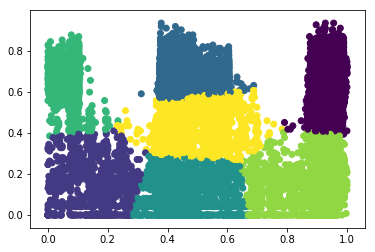

In [47]:
plt.scatter(
    data_subset.course_over_ground, 
    data_subset.speed_gps_kph,
    c=y_pred
)

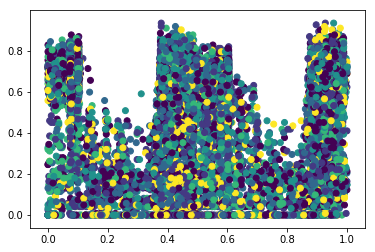

In [48]:
plt.scatter(
    data_subset.course_over_ground, 
    data_subset.speed_gps_kph,
    c=data_subset['weekday_map']
)

As can be seen by comparing the two images above, the clustering is not even close to the real values. The image on top shows the clusters as created by the KMeans algorithm. Those clusters are very well defined with clear boundaries. The image on the bottom colors each dot according to actual days of the week in the data, as can be seen, it's completely mixed and random. That's why I did not get predictive power in my previous models, because there are not any patterns I can leverage in the data.

### Cluster vehicles to identify weight with Agglomerative Clustering

In this case I will use Agglomerative Clustering with the Ward linkage. Again, I use only 5% of the normalized training data. If I use much more than that, the algorithm crashes as it's not designed to handle large amounts of data. I don't expect to get good results after seeing everything else.

In [49]:
variables = ['course_over_ground', 'speed_gps_kph']
data_subset = data_train_normalized
sample = np.random.rand(len(data_subset)) < 0.05
data_subset = data_subset[sample]

y_pred = AgglomerativeClustering(linkage='ward', n_clusters=2).fit_predict(data_subset[variables])

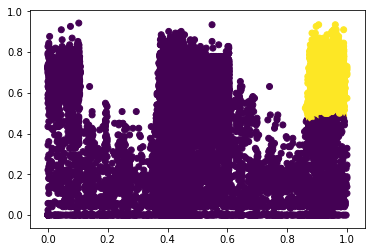

In [50]:
plt.scatter(
    data_subset.course_over_ground, 
    data_subset.speed_gps_kph,
    c=y_pred
)

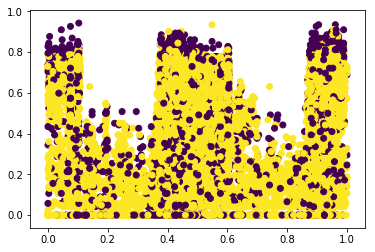

In [51]:
plt.scatter(
    data_subset.course_over_ground, 
    data_subset.speed_gps_kph,
    c=data_subset['weight_map']
)

As was expected, the real pattern (bottom image) is random, while the clustering pattern is well defined with clear boundaries. This is more evidence in favor of the lack of predictive power in our previous models. After seeing all these results, it seems to me that the dataset was not friendly towards predictive models due the lack of patterns inside, and I conclude that I can't make the predictions I was looking for.